<div class="alert alert-info" style="color:#004643"><h4><b><center>Cancer Image Segmentation using deep learning and transfer learning</b></h4></div> <a id="eda"></a>
<div>
<p>Authors:</p>
<p>&emsp;&emsp;Douglas Connolly (23053027)</p>
<p>&emsp;&emsp;Kenneth Onwuaha (23073022)</p>
<p>&emsp;&emsp;James Groth (23073283)</p>
</div>

## Abstract

We present a cancer classification system based on transfer learning and CNN image segmentation with the aim of accurately distinguishing between normal and circulating cancer cells (CTCs) within greyscale microscopy images. Many studies have used cellular morphology to identify CTCs within blood samples. However, most validation experiments include only homogeneous cell lines and inadequately captured the broad morphological heterogeneity of cancer cells. We have chosen to use organoid-derived microscopic images from 3 cholangiocarcinoma patients showing normal and cancerous cells. To improve cell detection, a VGG16 model was pre-trained with ImageNet and fine-tuned with single cell images; this formed the down sampling layers of the image segmentation model. The approach achieved a mean intersection over union (IOU) score of 21.8%.  More work is needed to improve the generalisation score, but automated detection and counting of CTCs provides an alternative to testing laboratories.   

In [2]:
# Execute if running on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pathlib
import cv2
import pickle
import copy
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import utils
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from warnings import filterwarnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
filterwarnings("ignore")
%matplotlib inline

# ##################################
# Global constants - amend as needed
# ##################################

# Set Root Directory...
# Local drive
# BASE_FOLDER = 'C:/Users/dougl/Documents/MSc A.I/Modules/AI Group Project'
# UWE network drive
# BASE_FOLDER = 'C:/Users/dougl/OneDrive - UWE Bristol/Documents - SCCT Student - Group project/A.I. Group 6 Project'
# Google Drive
# BASE_FOLDER = '/content/drive/My Drive/A.I. Group 6 Project'
BASE_FOLDER = '../..'

DATASET_FOLDER = f'{BASE_FOLDER}/Datasets/CTC_CCA_dataset'
MODEL_FOLDER = f'{BASE_FOLDER}/Models'
ANNOTATION_FOLDER = f'{DATASET_FOLDER}/annotations'
ANNOTATION_TRAIN_FOLDER = f'{ANNOTATION_FOLDER}/trainval'
ANNOTATION_TEST_FOLDER = f'{ANNOTATION_FOLDER}/test'
IMG_FOLDER = f'{DATASET_FOLDER}/raw_images_for_model'                            # 1207 images - we use only 1087
IMG_BF_FOLDER = f'{IMG_FOLDER}/brightfield'
IMG_FLR_FOLDER = f'{IMG_FOLDER}/fluorescence'
# RAW_CELL_IMG_FOLDER = f'{DATASET_FOLDER}/raw_cell_images'
# RAW_CELL_IMG_TRAIN_FOLDER =f'{RAW_CELL_IMG_FOLDER}/trainval/brightfield'       # 72,237 cell images
# RAW_CELL_IMG_TEST_FOLDER =f'{RAW_CELL_IMG_FOLDER}/test/brightfield'            # 8,930 cell images
CELL_IMG_FOLDER = f'{DATASET_FOLDER}/cell_images'
CELL_IMG_TRAIN_FOLDER =f'{CELL_IMG_FOLDER}/trainval/fluorescence'
CELL_IMG_TEST_FOLDER =f'{CELL_IMG_FOLDER}/test/fluorescence'

IMG_RESIZE = 224
VALIDATION_SPLIT = 0.15
EPOCHS=10
BATCH_SIZE = 32

# set constant to zero if want to process all the images
#
IMG_TRAIN_CNT = 0               # includes validation
IMG_TEST_CNT = 0
CELL_CLS_TRAIN_CNT = 3000       # per class, includes validation
CELL_CLS_TEST_CNT = 600         # per class

# cell model - transfer model trained with cell images
# segmentation model - weights and results using transfer models
CREATE_CELL_IMAGES = False
RETRAIN_CELL_MODEL = False
RETRAIN_IMG_MODEL = False
model_info = {
    'cell_train_weights'         : f'{MODEL_FOLDER}/cell_train.weights.h5',
    'cell_train_results'         : f'{MODEL_FOLDER}/cell_train.results.pkl',
    'img_train_nontuned_weights' : f'{MODEL_FOLDER}/img_train_nontuned.weights.h5',
    'img_train_nontuned_results' : f'{MODEL_FOLDER}/img_train_nontuned.results.pkl',
    'img_train_tuned_weights'    : f'{MODEL_FOLDER}/img_train_tuned.weights.h5',
    'img_train_tuned_results'    : f'{MODEL_FOLDER}/img_train_tuned.results.pkl',
    'img_test_nontuned_results'  : f'{MODEL_FOLDER}/img_test_nontuned.results.pkl',
    'img_test_tuned_results'     : f'{MODEL_FOLDER}/img_test_tuned.results.pkl'
}

## Transfer Learning and Feature Extraction

A key advantage of this appraoch is that you only run the base model once on your data, rather than once per epoch of training; it's a lot faster & cheaper

<ul>
<li>Instantiate a base model and load pre-trained weights into it.</li>
<li>Run the cell image dataset through it and extract the features from an output layer; preferrably the last convalution layer.</li>
<li>Use that output as input data for the segmentation model.</li>
</ul>

#### Create cleansed cell images from bounfding boxes

In [3]:
def get_annotation_files(path, max_files=0):
    annotation_files = list(pathlib.Path(path).glob('*.xml'))
    if len(annotation_files) == 0:
        raise UserWarning("No annotation files found - exiting process")
    print(f"There are {len(annotation_files):,} annotations in the XML folder")

    if max_files > 0:
        annotation_files = annotation_files[:max_files]
        print(f'User process limt set to {max_files} files')

    return annotation_files

def get_cell_cls_names(cell_dir):
    cls_names = []
    for sub_dir in [f for f in os.scandir(cell_dir) if f.is_dir()]:
        cls_names.append(sub_dir.name)
    return cls_names

def parse_xml(xml_file, cell_cls_names):
    '''add doc here ...
    '''
    chk_limit = lambda x,y: y if x > y else x

    cell_boxes = []
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # retrive image dimensions
    img_width = int(root.find('.//size/width').text) # type: ignore
    img_height = int(root.find('.//size/height').text) # type: ignore

    # bounding boxes - retrieve label and co-ordinates
    for elem in root.findall('.//object'):
        cell_cls = elem.find('name').text
        cell_cls_idx = cell_cls_names.index(cell_cls)

        x_min = int(elem.find('./bndbox/xmin').text)
        y_min = int(elem.find('./bndbox/ymin').text)
        x_max = int(elem.find('./bndbox/xmax').text)
        y_max = int(elem.find('./bndbox/ymax').text)

        # ensure max co-ordinates do not exceed image size
        x_max = chk_limit(x_max, img_width)
        y_max = chk_limit(y_max, img_height)

        bbox = [x_min, y_min, x_max, y_max, cell_cls_idx]
        cell_boxes.append(bbox)

    return np.array(cell_boxes), (img_width, img_height)

#
# Important: loaded images - shape is height, width, optionally channel(s)
#
def get_colour_image(xml_file):
    '''add docs here...
    '''
    img_id = os.path.splitext(os.path.basename(xml_file))[0]
    img_file = f'{IMG_FLR_FOLDER}/{img_id}.tiff'
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    return img, img_id

def generate_cell_images(annotation_files, cell_dir, cell_resize):
    """
    Generates a cleaner cell from an XML annotation file and a corresponding full image.

    Args:
        annotation_file_paths list(str): Paths to the XML annotation files.
        image_size tuple(int, int): The size of the image.

    Returns:
        none
    """
    cell_cls_names = get_cell_cls_names(cell_dir)
    rgb_cls_names = ['R','G','U']

    for xml_file in annotation_files:
        cell_boxes, img_size = parse_xml(xml_file, cell_cls_names)

        c_img, c_img_name = get_colour_image(xml_file)
        c_img = cv2.resize(c_img, img_size)

        # Create a blank multi-channel mask
        cell_cnt = 0
        c_threshold = 5

        for box in cell_boxes:
            x_min, y_min, x_max, y_max, box_cls = box
            cls_dir_name = cell_cls_names[box_cls]

            # Fill the bounding box region in the mask with the corresponding color
            cell_img = c_img[y_min:y_max, x_min:x_max]

            r_val = np.max(c_img[y_min:y_max, x_min:x_max, 0])
            g_val = np.max(c_img[y_min:y_max, x_min:x_max, 1])
            u_val = np.max(c_img[y_min:y_max, x_min:x_max, 2])

            # ignore type
            c_pixel_idx = np.argmax([r_val, g_val, u_val])
            c_pixel_val = int(np.max(cell_img))
            c_pixel_cls = cell_cls_names.index(rgb_cls_names[c_pixel_idx])

            # ensure the corresponding channel(color) is the most prominent in the cell region
            if c_pixel_val > c_threshold and c_pixel_cls == box_cls:
                cell_img = cv2.cvtColor(cv2.resize(cell_img, cell_resize), cv2.COLOR_RGB2BGR)
                fname = f'{c_img_name}_{cell_cnt}_{cls_dir_name}_{x_min}_{y_min}_{x_max}_{y_max}'
                cv2.imwrite(f"{cell_dir}/{cls_dir_name}/{fname}.tiff", cell_img)
                cell_cnt += 1

In [4]:
if CREATE_CELL_IMAGES:
    print('Creating new cell images from fluorescent full images...')
    files =  get_annotation_files(ANNOTATION_TRAIN_FOLDER)
    generate_cell_images(files, CELL_IMG_TRAIN_FOLDER, (IMG_RESIZE, IMG_RESIZE))

    files =  get_annotation_files(ANNOTATION_TEST_FOLDER)
    generate_cell_images(files, CELL_IMG_TEST_FOLDER, (IMG_RESIZE, IMG_RESIZE))

#### Process new cell images

---

In [8]:
def get_cell_images(cell_dir, img_resize, channels=3, max_imgs=0):
    cell_cls_names = []
    x = []
    y = []
    for sub_dir in [f for f in os.scandir(cell_dir) if f.is_dir()]:
        print(f'Processing {sub_dir.name} folder...')
        cell_cls_names.append(sub_dir.name)
        img_files = list(pathlib.Path(sub_dir.path).glob('*.tiff'))
        if max_imgs > 0:
            img_files = img_files[:max_imgs]

        for img_file in img_files:
            img = cv2.resize(cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE), img_resize)
            img = np.stack((img,)*channels, axis=-1)
            x.append(img)
            y.append(len(cell_cls_names)-1)

    print(f'Cell Classes: {cell_cls_names}')

    x = np.array(x)
    y = np.stack((y,), axis=-1)
    y = np.array(y, dtype=np.uint8)

    # randomise images/labels
    x, y = utils.shuffle(x, y)

    return x, y, cell_cls_names

#### Build Transfer Model using pre-trained weights

In [9]:
def load_weights(model, file, desc):
    try:
        model.load_weights(file)
        print(f'{desc} weights loaded successfully.')
    except Exception as e:
        print(f'Error loading {desc} weights:', e)
        raise
    return model

def load_results(file, desc):
    try:
        with open(file , 'rb') as f:
            results = pickle.load(f)
        print(f'{desc} results loaded successfully.')
    except Exception as e:
        print(f'error loading {desc} results:', e)
        raise
    return results

def save_results(results, file, desc):
    try:
        with open(file, 'wb') as f:
            pickle.dump(results, f)
            print(f'{desc} results saved successfully.')
    except Exception as e:
        print(f'Error loading {desc} results:', e)
        raise

def build_cell_model(input_dims, n_class):
    input = keras.layers.Input(shape=input_dims, name='input')
    x = keras.applications.vgg16.preprocess_input(input)

    base_model = keras.applications.VGG16 (
        weights='imagenet',
        include_top=False,
        input_shape=input_dims
        )
    base_model.trainable = False
    x = base_model(input)

    # replace fully connected layers
    x = keras.layers.Conv2D(filters=1024, kernel_size=3, padding="same", activation='relu', kernel_initializer="he_normal")(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    output = keras.layers.Dense(n_class, activation='softmax', name='output')(x)

    model = keras.Model(inputs=input, outputs=output,  name='cell_model')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

if RETRAIN_CELL_MODEL or not os.path.exists(model_info['cell_train_weights']):
    # Only load data sets if training
    x_cell_train, y_cell_train, cell_cls_names = get_cell_images(CELL_IMG_TRAIN_FOLDER, (IMG_RESIZE, IMG_RESIZE), max_imgs=CELL_CLS_TRAIN_CNT)
    print(f'Training data: X={x_cell_train.shape} Y={y_cell_train.shape}')

    x_cell_test, y_cell_test, cell_cls_names = get_cell_images(CELL_IMG_TEST_FOLDER, (IMG_RESIZE, IMG_RESIZE), max_imgs=CELL_CLS_TEST_CNT)
    print(f'Test data: X={x_cell_test.shape} Y={y_cell_test.shape}')

    # build cell model
    input_dims = (IMG_RESIZE, IMG_RESIZE, 3)
    cell_model = build_cell_model(input_dims, len(cell_cls_names))

    # train model - save results and weights
    train_results = cell_model.fit(
        x=x_cell_train,
        y=y_cell_train,
        validation_split=VALIDATION_SPLIT,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
        )

    cell_model.save_weights(model_info['cell_train_weights'])
    train_metrics = train_results.history
    save_results(train_metrics, model_info['cell_train_results'],  'cell training')

    cell_model.summary(show_trainable=True)
else:
    x_cell_test, y_cell_test, cell_cls_names = get_cell_images(CELL_IMG_TEST_FOLDER, (IMG_RESIZE, IMG_RESIZE), max_imgs=CELL_CLS_TEST_CNT)
    print(f'Test data: X={x_cell_test.shape} Y={y_cell_test.shape}')

    cell_model = build_cell_model((IMG_RESIZE, IMG_RESIZE, 3), len(cell_cls_names))
    if os.path.exists(model_info['cell_train_weights']):
        cell_model = load_weights(cell_model, model_info['cell_train_weights'], 'cell training')

    train_metrics = load_results(model_info['cell_train_results'], 'training')

Processing U folder...
Processing G folder...
Processing R folder...
Cell Classes: ['U', 'G', 'R']
Test data: X=(1460, 224, 224, 3) Y=(1460, 1)


2024-09-11 21:07:02.208833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


cell training weights loaded successfully.
training results loaded successfully.


#### Performance Metrics for cell model

Best Train accuracy: 0.859
Best Train loss: 0.364
Best validation accuarcy: 0.758
Best validation loss: 0.634


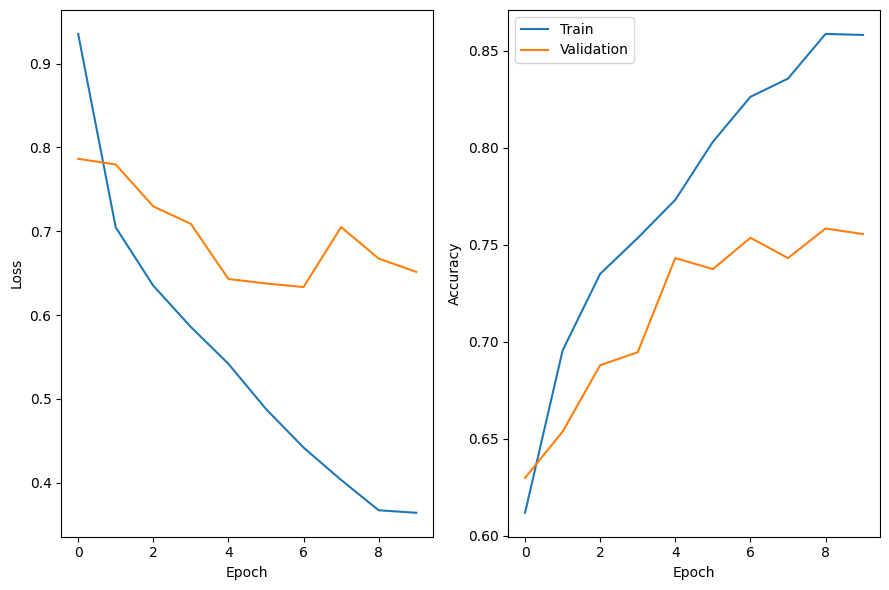

In [10]:
# Display training metrics
print(f"Best Train accuracy: {max(train_metrics['accuracy']):.3f}")
print(f"Best Train loss: {min(train_metrics['loss']):.3f}")
print(f"Best validation accuarcy: {max(train_metrics['val_accuracy']):.3f}")
print(f"Best validation loss: {min(train_metrics['val_loss']):.3f}")

fig, ax = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=False)
ax[0].plot(train_metrics['loss'], label='Train Loss')
ax[0].plot(train_metrics['val_loss'], label='Validation Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(train_metrics['accuracy'], label='Train Accuracy')
ax[1].plot(train_metrics['val_accuracy'], label='Validation Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')

plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step
              precision    recall  f1-score   support

           R     0.7409    0.8483    0.7910       600
           G     0.8531    0.7550    0.8011       600
           U     0.7107    0.6615    0.6853       260

    accuracy                         0.7767      1460
   macro avg     0.7683    0.7550    0.7591      1460
weighted avg     0.7816    0.7767    0.7763      1460



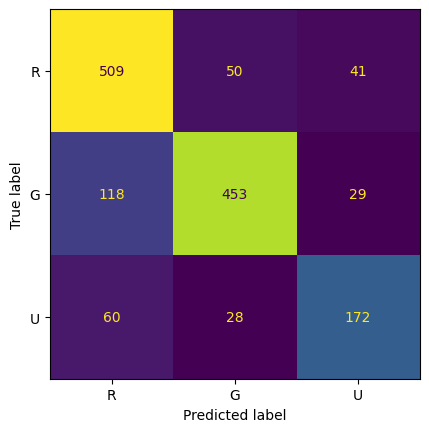

In [9]:
# get predictions
y_cell_pred = cell_model.predict(x_cell_test)
y_cell_pred = np.argmax(y_cell_pred, axis=1)

# show accuracy scores for class
labels = cell_cls_names
labels_idx = [i for i,e in enumerate(labels)]
print(classification_report(y_cell_test, y_cell_pred, digits=4, labels=labels_idx, target_names=labels))

# Print confusion matrix
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cell_test, y_cell_pred, colorbar=False, display_labels=labels)
plt.show()

### Image Segmentation and Classification

#### Load training data and pre-process full images

In [12]:
def display_images(display_list, title):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#
# Important: loaded images - shape is height, width, optionally channel(s)
#
def get_bw_image(xml_file):
    '''add docs here...
    '''
    img_id = os.path.splitext(os.path.basename(xml_file))[0]
    img_file = f'{IMG_BF_FOLDER}/{img_id}.tiff'
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return img, img_id

def generate_rgb_mask(annotation_files, cell_cls_names, img_resize):
    '''add docs here
    '''
    masks = []
    c_threshold = 1
    rgb_cls_names = ['R','G','U']

    for xml_file in annotation_files:
        # print(xml_file)
        # get the annotation data
        cell_boxes, img_size = parse_xml(xml_file, cell_cls_names)

        # correct wrong metadata
        w = 540 if img_size[0] > 540 else img_size[0]
        h = 540 if img_size[1] > 540 else img_size[1]
        img_size = (w,h)

        c_img,_ = get_colour_image(xml_file)
        c_img = cv2.resize(c_img, img_size)

        # assign labels to each pixel
        # note: image format is height x width
        mask = np.zeros((c_img.shape[0], c_img.shape[1], 3), dtype=np.uint8)

        for box in cell_boxes:
            x_min, y_min, x_max, y_max, box_cls = box
            if x_max > img_size[0]:
              x_max = img_size[0]
            if y_max > img_size[1]:
              y_max = img_size[1]

            # for each pixel, get most intense colour.
            # only assign class to pixel if class matches
            # image format - height x width so lead with y
            for h in range(y_min-1, y_max-1):
                for w in range(x_min-1, x_max-1):
                    # get the max pixel index(channel)
                    pixel_r_max_val = np.max(c_img[h, w, 0])
                    pixel_g_max_val = np.max(c_img[h, w, 1])
                    pixel_u_max_val = np.max(c_img[h, w, 2])

                    c_pixel_idx = np.argmax([pixel_r_max_val, pixel_g_max_val, pixel_u_max_val])
                    c_pixel_val = np.max([pixel_r_max_val, pixel_g_max_val, pixel_u_max_val])
                    c_pixel_cls = cell_cls_names.index(rgb_cls_names[c_pixel_idx])

                    # check that the pixel max index matches the box class
                    # assumes background is zero.
                    if c_pixel_cls == box_cls and c_pixel_val > c_threshold:
                        mask[h, w, c_pixel_idx] = 255

        mask = cv2.resize(mask, img_resize)
        masks.append(mask)

    return  np.array(masks)

def generate_dataset(annotation_files, cell_cls_names, img_resize):
    '''add docs here
    '''
    bw_imgs = []
    c_imgs=[]
    masks = []
    c_threshold = 1
    rgb_cls_names = ['R','G','U']

    for xml_file in annotation_files:
        # print(xml_file)
        # get the annotation data
        cell_boxes, img_size = parse_xml(xml_file, cell_cls_names)

        # correct wrong metadata
        w = 540 if img_size[0] > 540 else img_size[0]
        h = 540 if img_size[1] > 540 else img_size[1]
        img_size = (w,h)

        # get associated brightfield/flourescent images
        # resize to annotated size
        bw_img,_ = get_bw_image(xml_file)
        bw_img = cv2.resize(bw_img, img_size)

        c_img,_ = get_colour_image(xml_file)
        c_img = cv2.resize(c_img, img_size)

        # assign labels to each pixel
        # note: image format is height x width
        mask = np.zeros((bw_img.shape[0], bw_img.shape[1]), dtype=np.uint8)

        for box in cell_boxes:
            x_min, y_min, x_max, y_max, box_cls = box
            if x_max > img_size[0]:
              x_max = img_size[0]
            if y_max > img_size[1]:
              y_max = img_size[1]

            # for each pixel, get most intense colour.
            # only assign class to pixel if class matches
            # image format - height x width so lead with y
            for h in range(y_min-1, y_max-1):
                for w in range(x_min-1, x_max-1):
                    # get the max pixel index(channel)
                    pixel_r_max_val = np.max(c_img[h, w, 0])
                    pixel_g_max_val = np.max(c_img[h, w, 1])
                    pixel_u_max_val = np.max(c_img[h, w, 2])

                    c_pixel_idx = np.argmax([pixel_r_max_val, pixel_g_max_val, pixel_u_max_val])
                    c_pixel_val = np.max([pixel_r_max_val, pixel_g_max_val, pixel_u_max_val])
                    c_pixel_cls = cell_cls_names.index(rgb_cls_names[c_pixel_idx])

                    # check that the pixel max index matches the box class
                    # assumes background is zero.
                    if c_pixel_cls == box_cls and c_pixel_val > c_threshold:
                        mask[h, w] = c_pixel_cls


        # resize and convert to 3 channel for vgg16
        bw_img = cv2.resize(bw_img, img_resize)
        bw_img = np.stack((bw_img,)*3, axis=-1)

        # resize and convert to 1 channel for vgg model 16
        mask = cv2.resize(mask, img_resize)
        mask = np.stack((mask,), axis=-1)

        # just resize colour image
        c_img = cv2.resize(c_img, img_resize)

        # save processed data
        bw_imgs.append(bw_img)
        masks.append(mask)
        c_imgs.append(c_img)

    return np.array(bw_imgs), np.array(masks), np.array(c_imgs)

Image classes: ['Background', 'U', 'G', 'R']
There are 967 annotations in the XML folder
(967, 224, 224, 3) (967, 224, 224, 1) (967, 224, 224, 3)


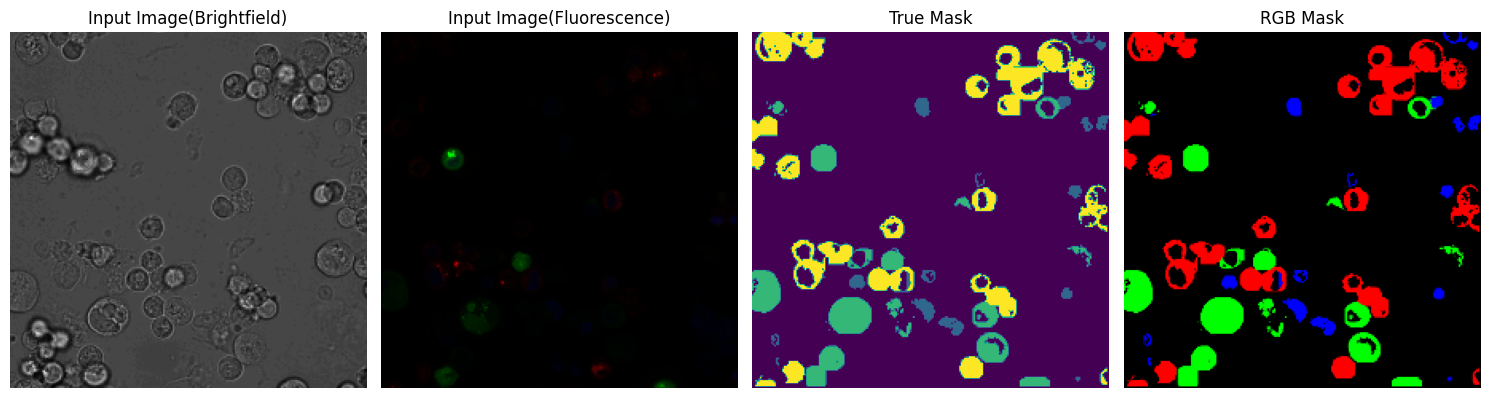

There are 120 annotations in the XML folder
(120, 224, 224, 3) (120, 224, 224, 1) (120, 224, 224, 3)


In [13]:
# add background avoid negative bias
img_cls_names = ['Background'] + cell_cls_names
print(f'Image classes: {img_cls_names}')

# load training/validation dataset (if needed)
files = get_annotation_files(ANNOTATION_TRAIN_FOLDER, IMG_TRAIN_CNT)
x_img_train, y_img_train, x_img_train_colour = generate_dataset(files, img_cls_names, (IMG_RESIZE, IMG_RESIZE))
print(x_img_train.shape, y_img_train.shape, x_img_train_colour.shape)

title = ['Input Image(Brightfield)', 'Input Image(Fluorescence)', 'True Mask', 'RGB Mask']
display_images([x_img_train[0], x_img_train_colour[0], y_img_train[0], generate_rgb_mask(files[:1], img_cls_names, (IMG_RESIZE, IMG_RESIZE))[0]], title)

# load test dataset
files =  get_annotation_files(ANNOTATION_TEST_FOLDER, IMG_TEST_CNT)
x_img_test, y_img_test, x_img_test_colour = generate_dataset(files, img_cls_names, (IMG_RESIZE, IMG_RESIZE))
print(x_img_test.shape, y_img_test.shape, x_img_test_colour.shape)

img_data = {
    'x_train': x_img_train,
    'y_train': y_img_train,
    'x_test': x_img_test,
    'y_test': y_img_test,
    'x_train_colour': x_img_train_colour,
    'x_test_colour': x_img_test_colour
}

#### Train Segmentation Model

In [14]:
def build_img_model(input_dims, n_class, vanilla):
    inputs = keras.layers.Input(shape=input_dims, name='input')
    x = keras.applications.vgg16.preprocess_input(inputs)

    # pre-processing steps
    x = keras.layers.RandomFlip('horizontal', name='horizontal_flip')(x)
    x = keras.layers.RandomRotation(0.1, name='rotation')(x)

    # retreive layers from cell/transfer model
    cell_model = build_cell_model(input_dims, len(cell_cls_names))
    if not vanilla:
        cell_model = load_weights(cell_model, model_info['cell_train_weights'], 'Cell Model')
    base_model = cell_model.get_layer('vgg16')

    # save final conv layer in each block for back propogation
    residuals=[]
    filters = []
    conv_layer =None
    for layer in base_model.layers[1:]:
        layer.trainable = False
        x = layer(x)
        if isinstance(layer, keras.layers.MaxPooling2D):
            residuals.append(conv_layer)
            filters.append(conv_layer.shape[3])
        if isinstance(layer, keras.layers.Conv2D):
            conv_layer = x

    # final conv layer has no max pooloing so need for back propogation
    for layer in cell_model.layers:
        if isinstance(layer, keras.layers.Conv2D):
            layer.trainable = True
            x = layer(x)

    # add upsample layers
    for filter in reversed(filters):
        # Transpose convolution
        x = keras.layers.Conv2DTranspose(filter, kernel_size=2, strides=2, activation='relu', padding="same", kernel_initializer="he_normal")(x)
        x = keras.layers.concatenate([x, residuals.pop()])
        # Two convolutions
        x = keras.layers.Conv2D(filter, kernel_size=3, activation='relu', padding="same", kernel_initializer="he_normal")(x)
        x = keras.layers.Conv2D(filter, kernel_size=3, activation='relu', padding="same", kernel_initializer="he_normal")(x)
        if filter > 128:
            x = keras.layers.Conv2D(filter, kernel_size=3, activation='relu', padding="same", kernel_initializer="he_normal")(x)

    # Output layer
    outputs = keras.layers.Conv2D(filters=n_class, kernel_size=1, activation="softmax", name='per-pixel_clsf')(x)

    # Create intersection over union metric
    seg_iou = tf.keras.metrics.MeanIoU(num_classes=n_class, sparse_y_true=True, sparse_y_pred=False, name='iou')

    # Compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='segmentation_model')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[seg_iou])

    return model

def train_img_model(model, data, val_split, epochs, batch_size, w_file, r_file, desc):

    model_chkptr = tf.keras.callbacks.ModelCheckpoint(
            w_file,
            monitor='loss',
            verbose=0,
            save_best_only=True,      # save trained weights (best values)
            save_weights_only=True,   #
            mode='min',
            save_freq='epoch')

    model_earlystp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=10,
        verbose=0,
        mode="min",
        restore_best_weights=True)

    # Fit the model (best weights saved)
    results = model.fit(
        x=data['x_train'],
        y=data['y_train'],
        epochs=epochs,
        validation_split=val_split,
        batch_size=batch_size,
        callbacks=[model_chkptr,model_earlystp],
        verbose=2
        )

    # Save results
    results = results.history
    save_results(results, r_file, desc)

    return results

def do_training(data, w_file, r_file, cls_names, vanilla=False):

    # process description
    desc = 'non-tuned' if vanilla else 'tuned'
    desc = f'Segmentation training ({desc} transfer model)'

    # define model
    img_model = build_img_model((IMG_RESIZE, IMG_RESIZE, 3), len(cls_names), vanilla)

    # If we have previous weights, training is not necessary
    if RETRAIN_IMG_MODEL or not (os.path.exists(w_file) and os.path.exists(r_file)):
        metrics = train_img_model(img_model, data, VALIDATION_SPLIT, EPOCHS, BATCH_SIZE, w_file, r_file, desc)
    else:
        # we still need to reload weights/metrics
        load_weights(img_model, w_file, desc)
        metrics = load_results(r_file, desc)

    return img_model, metrics

In [15]:
# perform segmentation using non-tuned transfer models
img_model1, train_m1 = do_training(
    img_data,
    w_file = model_info['img_train_nontuned_weights'],
    r_file = model_info['img_train_nontuned_results'],
    cls_names = img_cls_names,
    vanilla = True
    )
print(f'Segmentation Mode (non-tuned transfer model) - training metrics...\n{train_m1}\n')
img_model1.summary()

# perform segmentation using tuned transfer models
img_model2, train_m2 = do_training(
    img_data,
    w_file = model_info['img_train_tuned_weights'],
    r_file = model_info['img_train_tuned_results'],
    cls_names = img_cls_names
    )
print(f'Segmentation Mode (non-tuned transfer model) - training metrics...\n{train_m2}\n')

Segmentation training (non-tuned transfer model) weights loaded successfully.
Segmentation training (non-tuned transfer model) results loaded successfully.
Segmentation Mode (non-tuned transfer model) - training metrics...
{'iou': [0.19879095256328583, 0.2079254388809204, 0.2051248848438263, 0.20279088616371155, 0.21475155651569366, 0.2135506570339203, 0.20920054614543915, 0.21568980813026428, 0.21606464684009552, 0.21592192351818085], 'loss': [53.96062469482422, 5.279540061950684, 4.090764999389648, 3.9567296504974365, 1.493149995803833, 1.2664538621902466, 1.4422870874404907, 0.9603181481361389, 0.7362074851989746, 0.6923549175262451], 'val_iou': [0.21371905505657196, 0.2244134545326233, 0.21584029495716095, 0.21937841176986694, 0.2359672337770462, 0.2033715546131134, 0.22133414447307587, 0.23286668956279755, 0.234499990940094, 0.23127451539039612], 'val_loss': [8.900996208190918, 5.716504096984863, 3.799867868423462, 2.5965576171875, 1.1551969051361084, 1.3928111791610718, 1.1240764

Model: "segmentation_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ horizontal_flip     │ (None, 224, 224,  │          0 │ add_1[0][0]       │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation            │ (None, 224, 224,  │          0 │ horizontal_flip[… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ rotation[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[1][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[1][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[1][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[1][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[1][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[1][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 45,060,740 (171.89 MB)

 Trainable params: 30,346,052 (115.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Cell Model weights loaded successfully.
Segmentation training (tuned transfer model) weights loaded successfully.
Segmentation training (tuned transfer model) results loaded successfully.
Segmentation Mode (non-tuned transfer model) - training metrics...
{'iou': [0.20264887809753418, 0.20556870102882385, 0.20912577211856842, 0.2090175747871399, 0.20693720877170563, 0.20501194894313812, 0.2069132924079895, 0.21411015093326569, 0.2164234071969986, 0.21640101075172424], 'loss': [56.01581573486328, 4.12995719909668, 2.1293468475341797, 1.8675543069839478, 3.952770948410034, 3.45357084274292, 1.8942722082138062, 1.3226268291473389, 0.8259578347206116, 0.7203398942947388], 'val_iou': [0.2179262340068817, 0.2228751927614212, 0.15958501398563385, 0.21924299001693726, 0.1571425199508667, 0.08758098632097244, 0.23182758688926697, 0.23576906323432922, 0.2358781099319458, 0.23519429564476013], 'val_loss': [7.404083728790283, 2.9360291957855225, 2.3126888275146484, 4.327062129974365, 4.267124652862

#### Performance Metrics for segmentation model

<p>
Pixel accuracy metric calculates the percentage of pixels that were correctly classified according to the segmentation mask. Unfortunately, with very sparse class representations the pixel accuracy will be biased towards negative cases. We have addressed thsi issue by assigning a class to the background as well as opting for mean intersection over union (IOU). For our ground truth and predicted segmenation masks, we count the number of pixels that overlap and divide by the total area of both masks; value will be 0-1, the higher the value, the better.
</p>
<p>&emsp;IOU = <u>number of overlapping pixels (intersection)</u></br>&emsp;&emsp;&emsp;&emsp;True area + Predicted area − intersection</p>

Dice coefficient will the same answer but maybe not the same value; we will use IOU.

Segmenation Metrics (non-tuned transfer model) results loaded successfully.
Segmenation Metrics (non-tuned transfer model)...
Best Train loss: 0.692
Best Train seg iou: 0.216
Best validation loss: 0.751
Best validation seg iou: 0.236
Test loss: 0.738
Test seg iou: 0.228


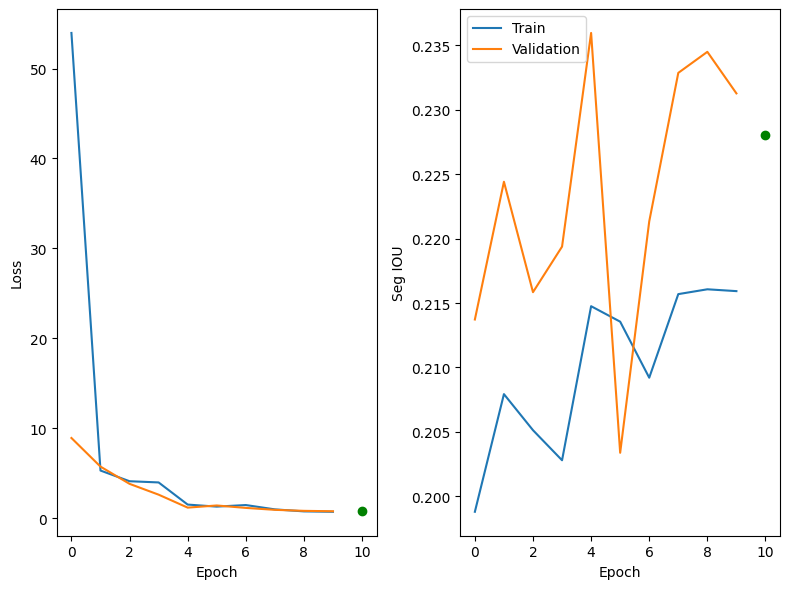

Segmenation Metrics (tuned transfer model) results loaded successfully.
Segmenation Metrics (tuned transfer model)...
Best Train loss: 0.720
Best Train seg iou: 0.216
Best validation loss: 0.781
Best validation seg iou: 0.236
Test loss: 0.762
Test seg iou: 0.233


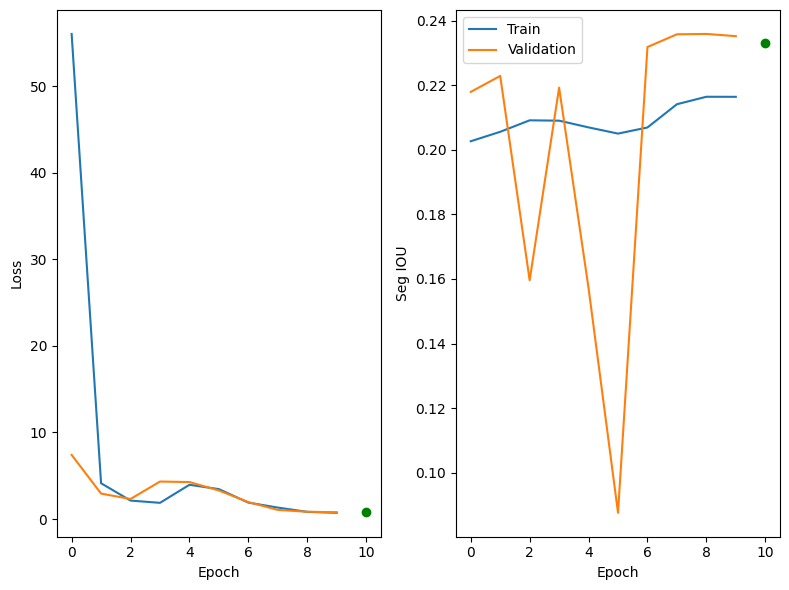

In [16]:

def evaluate_model(model, data, r_file, r_desc, vanilla=False):

    if RETRAIN_IMG_MODEL or not os.path.exists(r_file):
        metrics = model.evaluate(x=data['x_test'], y=data['y_test'])
        save_results(metrics, r_file, r_desc)
    else:
        metrics = load_results(r_file, r_desc)

    return metrics

# plot loss and IOU metrics
def display_metrics(train_m, test_m, title):

    print(f'{title}...')
    print(f"Best Train loss: {min(train_m['loss']):.3f}")
    print(f"Best Train seg iou: {max(train_m['iou']):.3f}")
    print(f"Best validation loss: {min(train_m['val_loss']):.3f}")
    print(f"Best validation seg iou: {max(train_m['val_iou']):.3f}")
    print(f"Test loss: {test_m[0]:.3f}")
    print(f"Test seg iou: {test_m[1]:.3f}")

    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
    # fig.suptitle(title)

    ax[0].plot(train_m['loss'], label='Train Loss')
    ax[0].plot(train_m['val_loss'], label='Validation Loss')
    ax[0].scatter(len(train_m['loss']), test_m[0], label='Test Loss', color='green')
    ax[0].set(xlabel='Epoch', ylabel='Loss')

    ax[1].plot(train_m['iou'], label='Train IOU')
    ax[1].plot(train_m['val_iou'], label='Validation IOU')
    ax[1].scatter(len(train_m['iou']), test_m[1], label='Test IoU', color='green')
    ax[1].set(xlabel='Epoch', ylabel='Seg IOU')

    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

# perform evaluation and display results for tuned/untuned transfer models
desc = 'Segmenation Metrics (non-tuned transfer model)'
test_m1 = evaluate_model(img_model1, img_data, model_info['img_test_nontuned_results'], desc, vanilla=True)
display_metrics(train_m1, test_m1, desc)

# perform evaluation and display results for tuned/untuned
desc = 'Segmenation Metrics (tuned transfer model)'
test_m2 = evaluate_model(img_model2, img_data, model_info['img_test_tuned_results'], desc)
display_metrics(train_m2, test_m2, desc)

##### Testing the Segmentation Models

In [17]:
y_img_pred1 = img_model1.predict(x_img_test)
y_img_pred2 = img_model2.predict(x_img_test)

y_img_pred_classes1 = [np.argmax(pred, -1) for pred in y_img_pred1]
y_img_pred_classes2 = [np.argmax(pred, -1) for pred in y_img_pred2]

2024-09-11 22:28:10.614551: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-11 22:28:10.902772: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-11 22:28:12.276534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-09-11 22:28:12.366550: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-09-11 22:28:13.231975: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 35s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 138s 34s/step


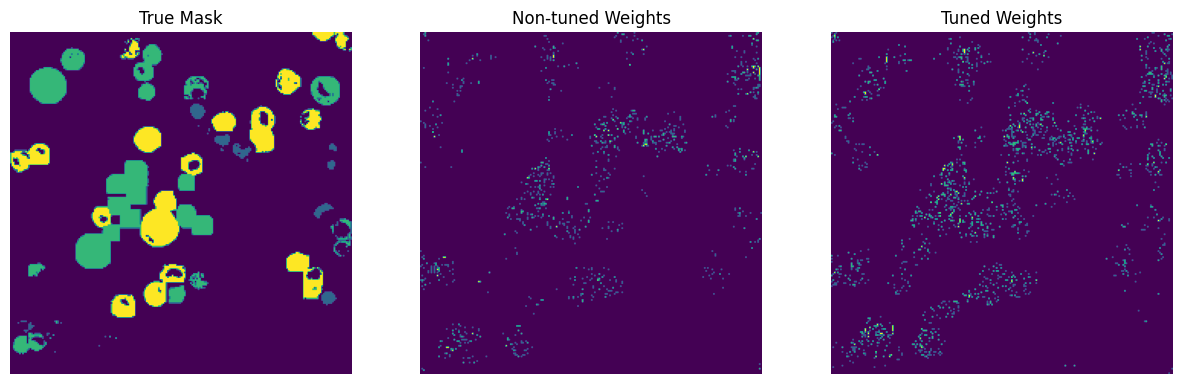

In [18]:
_, ax = plt.subplots(1, 3, figsize=(15, 15));
ax = ax.ravel()

ax[0].imshow(y_img_test[0]);
ax[0].set_title('True Mask');
ax[0].axis('off');
ax[1].imshow(y_img_pred_classes1[0]);
ax[1].set_title('Non-tuned Weights');
ax[1].axis('off');
ax[2].imshow(y_img_pred_classes2[0]);
ax[2].set_title('Tuned Weights');
ax[2].axis('off');